# NLP Mark Manson

In this repo I have scraped all of the articles on Mark Manson's website and performed analysis on it.   

The scrapers can be seen in [scrape_articles.py](../scraper/scrape_articles.py).   

In [2]:
import string
import re
import sys

import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from wordcloud import WordCloud

import datetime

import sqlite3
import numpy as np
import pandas as pd

import Summarizer_HuggingFace_Abstractive
import LatentDirichletAllocation_Gensim

# $ pip install nltk
# $ python
# >> nltk.download('stopwords')
# >> nltk.download('punkt')
# >> nltk.download('wordnet')
# >> nltk.download('omw-1.4')
# >> nltk.download('averaged_perceptron_tagger')
# >> nltk.download('universal_tagset')
# quit()
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

DATABASE_NAME="../data/articles.db"

import warnings
warnings.filterwarnings('ignore')

/Users/michaelhammer/Documents/Coding_Projects/NLPMarkManson/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create Some Helper Functions

In [3]:
def get_file_text(filepath, line_divider=" "):
    '''
    This function joins all the lines into a single string and removes any newlines
    '''
    lines = []
    with open(filepath) as f:
        lines = f.readlines()
    return "{}".format(line_divider).join(lines).replace("\n", " ")

def get_num_words(text):
    word_tokens = word_tokenize(text)

    # remove the punctuation
    punc_list = set(string.punctuation)
    punc_free_words = [w for w in word_tokens if w not in punc_list]
    alphanumeric_words = [w for w in punc_free_words if (w.isalnum())]

    return len(alphanumeric_words)


def clean_text(text):
    # lowercase the words
    lowercase_text = text.lower()
    
    # convert text into a list of words (tokens)
    word_tokens = word_tokenize(lowercase_text)

    # Remove Stop Words
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
    stop_free_words = [w for w in word_tokens if w not in stop_words]

    # lemmatize the words
    lemmatizer = WordNetLemmatizer()
    lammatized_words = [lemmatizer.lemmatize(w) for w in stop_free_words]

    # remove the punctuation
    punc_list = set(string.punctuation)
    punc_free_words = [w for w in lammatized_words if w not in punc_list]
    alphanumeric_words = [w for w in punc_free_words if (w.isalnum())]

    # Stem the words
    # ps = PorterStemmer()
    # stemmed_words = [ps.stem(w) for w in lammatized_words]

    return " ".join(alphanumeric_words)

In [4]:

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect(DATABASE_NAME)
df = pd.read_sql_query("SELECT * from articles", con, index_col ="name")
con.close()

# Initialize columns in the dataframe
df["text"] = ""
df["tokens"] = ""
df["raw_text"] = ""
df["raw_text_sentences"] = ""
df["num_words"] = ""

long_string_list = [] # used for the Word Cloud
article_words_list = []

for i, row in df.iterrows():
    # Get raw file text
    filepath = row["filepath"]
    raw_text = get_file_text(filepath)
    raw_text_sentences = get_file_text(filepath, line_divider=" . ")
    
    # Clean the text
    cleaned_text = clean_text(raw_text)
    row["raw_text"] = raw_text
    row["raw_text_sentences"] = raw_text_sentences
    row["text"] = cleaned_text
    
    # Get tokens
    word_tokens = word_tokenize(cleaned_text)
    row["tokens"] = word_tokens
    article_words_list.append(word_tokens)

    long_string_list.append(cleaned_text)

    row["num_words"] = get_num_words(raw_text)


## Create a Word Cloud

In [5]:
def create_word_cloud(long_string):
    #  Create a WordCloud object
    wordcloud = WordCloud(background_color="white", width=1600, height=800, max_words=200, contour_width=3, contour_color='steelblue')
    
    # Generate a word cloud
    wordcloud.generate(long_string)
    
    # Visualize the word cloud
    plt.figure(figsize = (20,10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

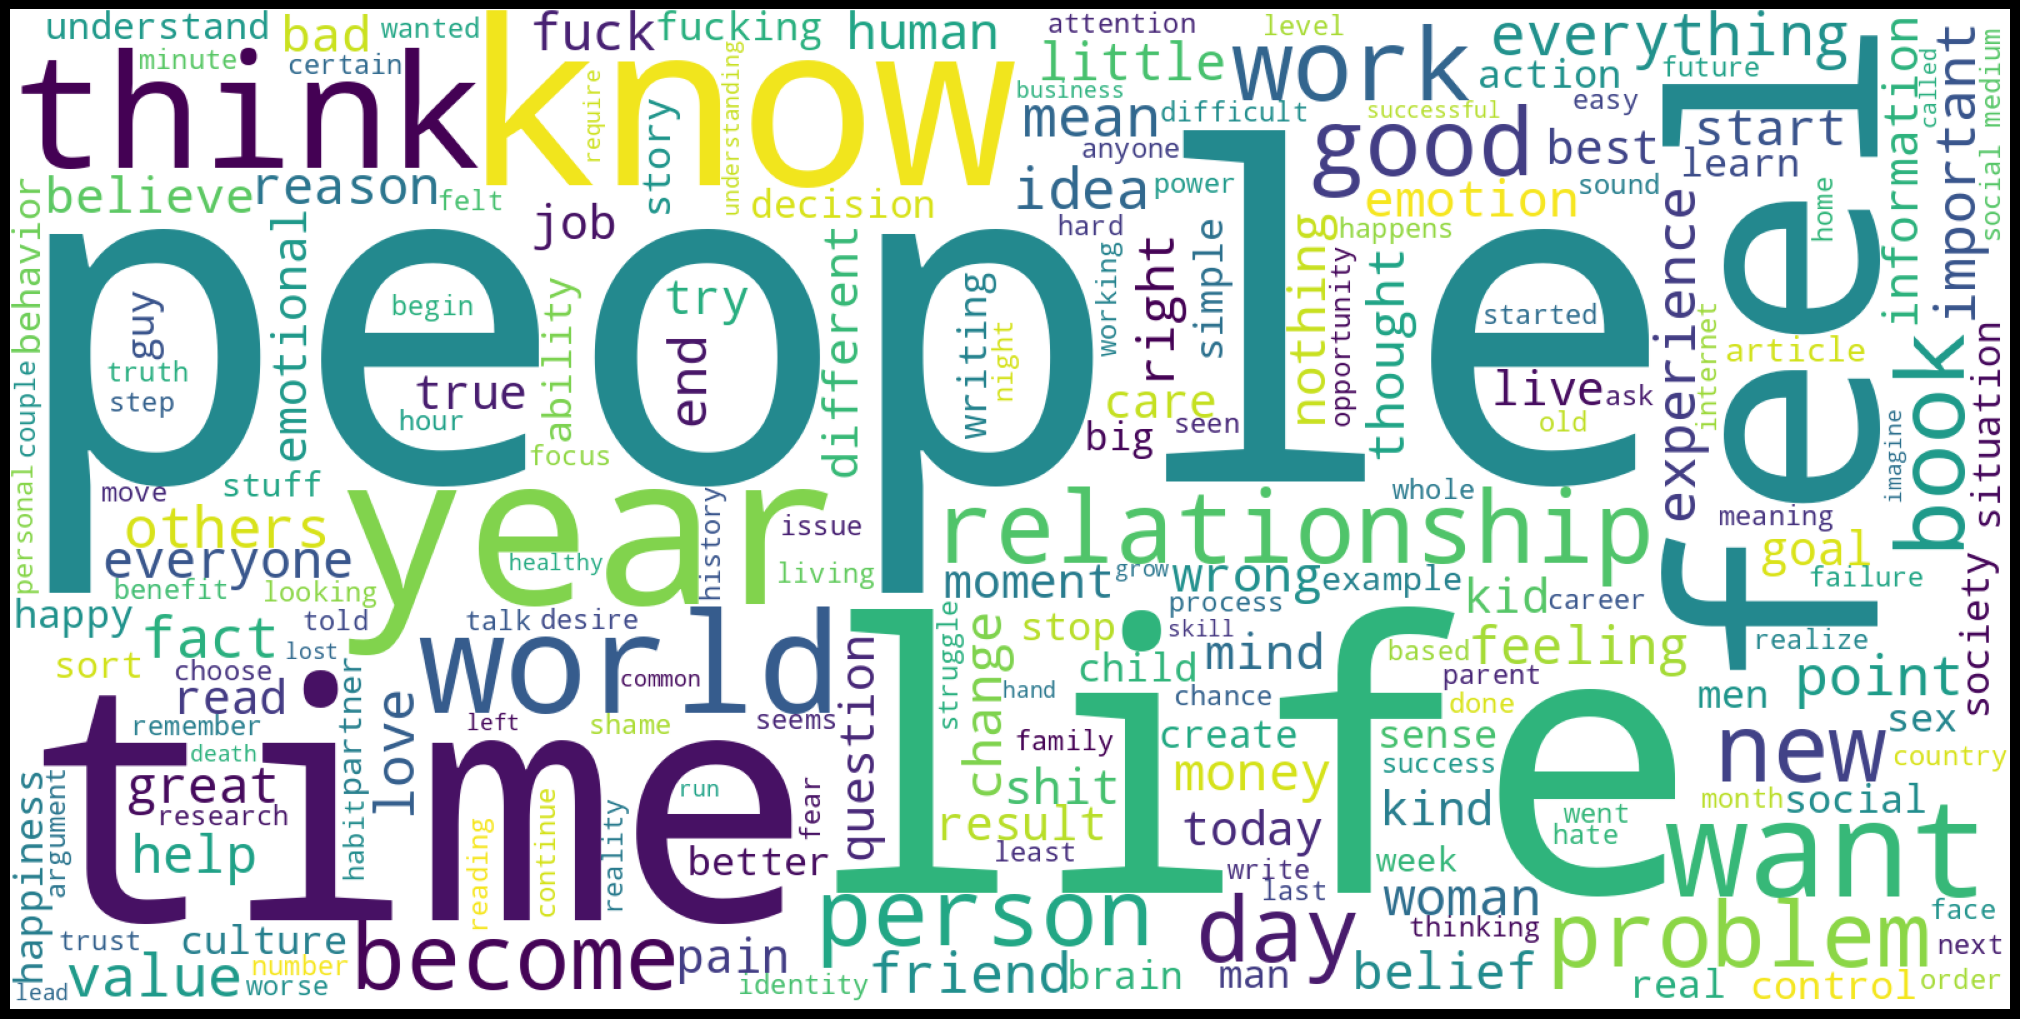

In [6]:

long_string = " ".join(long_string_list)

token_words = long_string.split(" ")
pos_tags = nltk.pos_tag(token_words, tagset='universal')
boring_words = ["much", "got", "u", "take", "going", "yet", "lot", "may", "must", "thing", 
"likely", "could", "let", "able", "often", "well", "see", "give", "really", "way", "even",
 "every", "back", "one", "make", "still", "actually", "come", "something", "rather", "le", 
 "two", "many", "put", "maybe", "say", "said", "far", "keep", "look", "call", "turn", "part",
  "either", "sometime", "pretty", "tell", "seem", "happen", "second", "first", "form", "around", 
  "getting", "go", "might", "place", "another", "sure", "course", "made", "need", "case", "found",
  "find", "cause", "show", "making", "anything", "matter", "someone", "used", "trying", "word", "saying",
  "happening"]
cool_words = []
for i in range(len(token_words)):
    if pos_tags[i][1] in ["NOUN", "VERB", "ADJ"] and pos_tags[i][0] not in boring_words:
        cool_words.append(token_words[i])

long_string = " ".join(cool_words)


create_word_cloud(long_string)


## Some Fun Graphs

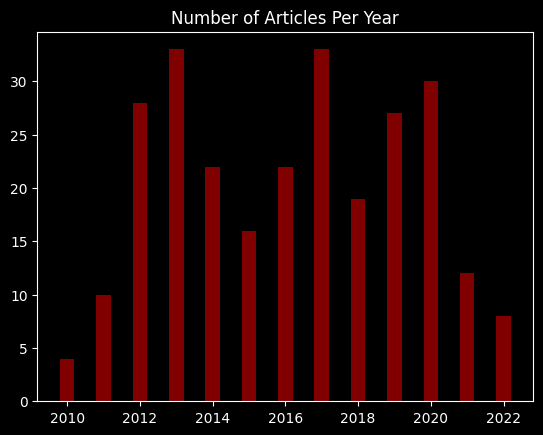

In [7]:
dates_df = pd.to_datetime(df['date'])
years_df = dates_df.dt.year
unique_years = years_df.unique()
num_articles = []
for year in unique_years:
    include = df[dates_df.dt.year == year]
    num_rows = include.shape[0]
    num_articles.append(num_rows)
plt.bar(unique_years, num_articles, color ='maroon',
        width = 0.4)
plt.title("Number of Articles Per Year")
plt.show()

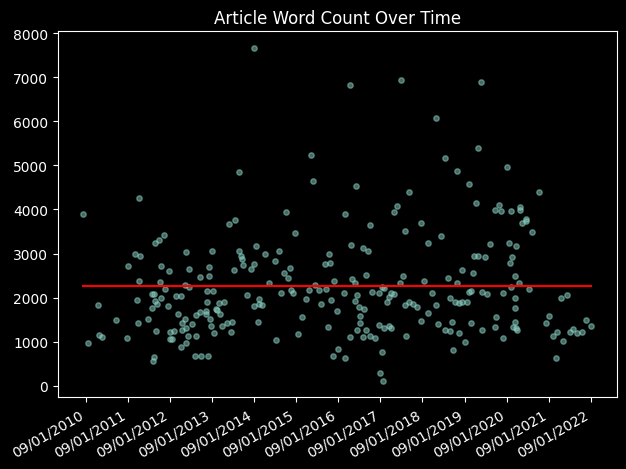

In [13]:
dates_strings = df["date"].to_numpy()
dates = [datetime.datetime.strptime(d, '%Y-%m-%d') for d in dates_strings]
avg_len = sum(df["num_words"]) / len(df["num_words"])
avg_len_points = [avg_len for i in range(len(dates))]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.scatter(dates, df["num_words"], s=15, alpha=0.5)
plt.plot(dates, avg_len_points, color="red")
plt.gcf().autofmt_xdate()
plt.title("Article Word Count Over Time")
plt.tight_layout()
plt.show()

# Topic Modeling (LDA)

In [14]:

# Instantiate the Model Class
lda = LatentDirichletAllocation_Gensim.LatentDirishletAllocation()

# Specify Hyperparameters (Note: I performed hyperparameter tuning outside of this notebook)
num_topics = 6
no_below = 25
no_above = 0.50
id2word_dictionary = lda.create_dictionary(article_words_list, no_below, no_above)
lda.create_bag_of_words_corpus()

# Create a model or load an existing one (TODO: programatically check if the model exists)
# lda_model = lda.create_model(num_topics)
# lda.save_model()
lda_model = lda.load_model()

coherence = lda.get_coherence_score() # Evaluation Metric

print(coherence)


-1.0095429881288538


In [15]:

# Print the key words for each topic found 
topics_data = {}
topicid_word_tuples = lda_model.show_topics(num_topics=num_topics, num_words=12, formatted=False)
for topicid_word_tuple in topicid_word_tuples:
    topic_id = topicid_word_tuple[0]
    topic_words_probability_tuples = topicid_word_tuple[1]
    words_list = [w[0] for w in topic_words_probability_tuples]
    words_string = " ".join(words_list)
    print("{}: {}".format(topic_id, words_string))
    topics_data[topic_id] = {
        "topic_words_probability_tuples": topic_words_probability_tuples,
        "clean_words": words_string,
        "words_list": words_list
    }

# After manually looking at the topics and articles I created these titles for the topics
topics_data[0]["Name"] = "World Information - News, Social Media"
topics_data[1]["Name"] = "The Mind - Brain, Reading, Learning, Philosophy"
topics_data[2]["Name"] = "Sex and Dating Women"
topics_data[3]["Name"] = "Resilience Against Life"
topics_data[4]["Name"] = "Pursuit of a Happy Life"
topics_data[5]["Name"] = "Relationship Advice"


0: medium information news attention country health culture today internet read history society
1: belief read philosophy eye page brain trust understanding hope reading question identity
2: woman value men sex goal sexual man culture girl guy young definition
3: emotion shame step hour fucking felt week level stop habit night pain
4: emotion happiness meaning happy decision negative value pain brain control positive bias
5: partner job parent together dating respect question read word healthy yes behavior


In [16]:

# Print all the articles for each topic

df["topic_id"] = ""
for i, row in df.iterrows():
    article_word_tokens = row["tokens"]
    article_bag_of_words = id2word_dictionary.doc2bow(article_word_tokens)
    article_topic_distribution_tuples = lda_model.get_document_topics(article_bag_of_words, per_word_topics=False)
    
    # Get the TopicID that has the greatest probability
    max_tuple = max(article_topic_distribution_tuples, key=lambda x:x[1])
    max_topic_id = max_tuple[0]
    row["topic_id"] = max_topic_id
    
    # Add the file to that topic
    filepath = row["filepath"]
    if "articles" not in topics_data[max_topic_id]:
        topics_data[max_topic_id]["articles"] = []
    topics_data[max_topic_id]["articles"].append(i)


for key, value in topics_data.items():
    print("Topic-{} {}) {}".format(key, value["Name"], value["clean_words"]))
    articles = value["articles"]
    print(", ".join(articles))
    print()


Topic-0 World Information - News, Social Media) medium information news attention country health culture today internet read history society
trigger-warning, are-you-not-entertained, 3-principles-for-a-better-life, the-life-cycle-of-outrage, you-are-what-you-consume, benefits-of-time, social-media-isnt-the-problem, 4-ways-my-views-have-changed, favorite-books-2020, how-to-get-better, a-slow-moving-car-wreck, unintended-consequences, how-to-overcome-loneliness, logical-fallacies, the-best-and-the-worst-of-someone, chaos-and-uncertainty, the-dangers-of-distrust, why-you-should-quit-the-news, 10-important-lessons-from-the-2010s, three-months-later-does-the-attention-diet-work, the-death-of-tourism, principles-of-productivity, attention-diet, managing-your-mental-health, lifelong-learning, is-no-one-safe-from-the-bullshit, 5-books-that-explain-why-it-seems-the-world-is-so-fucked, 6-things-people-should-stop-giving-so-many-fucks-about, read-fiction, 3-simple-ideas, benefits-of-being-slightl

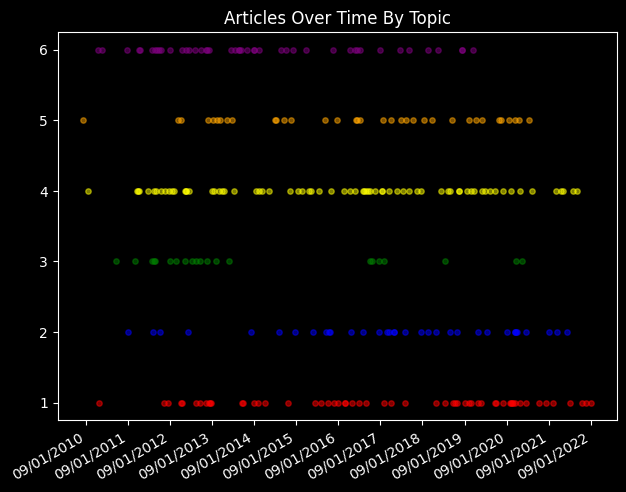

In [18]:

# Print each of the topics over time

dates_strings = df["date"].to_numpy()
dates = [datetime.datetime.strptime(d, '%Y-%m-%d') for d in dates_strings]

topic_ids = df["topic_id"].to_numpy() + 1
topic1_ids = (topic_ids == 1)*1
topic1_ids = np.array([id if id != False else None for id in topic1_ids])
topic2_ids = (topic_ids == 2)*2
topic2_ids = np.array([id if id != False else None for id in topic2_ids])
topic3_ids = (topic_ids == 3)*3
topic3_ids = np.array([id if id != False else None for id in topic3_ids])
topic4_ids = (topic_ids == 4)*4
topic4_ids = np.array([id if id != False else None for id in topic4_ids])
topic5_ids = (topic_ids == 5)*5
topic5_ids = np.array([id if id != False else None for id in topic5_ids])
topic6_ids = (topic_ids == 6)*6
topic6_ids = np.array([id if id != False else None for id in topic6_ids])

dot_size=15
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.scatter(dates,topic1_ids, color="red", label=topics_data[0]["Name"], s=dot_size, alpha=0.5)
plt.scatter(dates,topic2_ids, color="blue", label=topics_data[1]["Name"], s=dot_size, alpha=0.5)
plt.scatter(dates,topic3_ids, color="green", label=topics_data[2]["Name"], s=dot_size, alpha=0.5)
plt.scatter(dates,topic4_ids, color="yellow", label=topics_data[3]["Name"], s=dot_size, alpha=0.5)
plt.scatter(dates,topic5_ids, color="orange", label=topics_data[4]["Name"], s=dot_size, alpha=0.5)
plt.scatter(dates,topic6_ids, color="purple", label=topics_data[5]["Name"], s=dot_size, alpha=0.5)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.title("Articles Over Time By Topic")
plt.show()
# TODO: Create better labels on the graph

The above graph is really cool. Each color represents a different topic that Mark Manson talked about. 
1. "World Information - News, Social Media"
2. "The Mind - Brain, Reading, Learning, Philosophy"
3. "Sex and Dating Women"
4. "Resilience Against Life"
5. "Pursuit of a Happy Life"
6. "Relationship Advice"

You can see that he started by talking about Relationship Adice (6), and Sex and Dating Women (3) but stopped over time. Now he talks more about World Information, the Mind, Resilience, and the pursuit of a Happy Life. 

This makes sense based on the books Mark Manson has written. He first wrote "Models" about dating and relationships and then moved to books like "The Subtle Art of Not Giving a F*ck". 


# Text Summarization

### Summarize His Topics

Gather all the articles for each topic and summarize what he says using extractive summarization and abstractive summarization.

In [21]:
# Get text for each topic
topic_ids = df['topic_id']
unique_topics = topic_ids.unique()
topic_sumamry_map = {}
    

import Summarizer_HuggingFace_Abstractive
import Summarizer_Extractive

for id in unique_topics:
    topic_name = topics_data[id]["Name"]
    important_words = topics_data[id]["words_list"]
    print("Topic {} {} =======================================================".format(id, topic_name))
    include_df = df[df["topic_id"] == id]
    topic_text = include_df["raw_text_sentences"]
    topic_text_array = list(topic_text.to_numpy())
    # Hacky data cleaning to get rid of this phrase it thought was important
    topic_text_array = [t.replace("This is a new Mindf*ck Monthly newsletter", "").replace("This is a Mindf*ck Monthly newsletter", "").replace("Mindf*ck Monthly newsletter", "") for t in topic_text_array]
    
    print("Extractive Summaries of each article...")
    topic_text_array_extractive = [Summarizer_Extractive.extractive_summarize(t, num_sentences=20) for t in topic_text_array]
    all_topic_text_extractive = " ".join(topic_text_array_extractive)
    
    print("Extractive Summary of All Articles:")
    summary = Summarizer_Extractive.extractive_summarize(all_topic_text_extractive, num_sentences=5)
    print(summary)
    print()

    # First get the most imoprtant sentences using extractive summarization and then pass it to the abstractive summarizer
    print("Abstractive Summary of All Articles:")
    summary = Summarizer_HuggingFace_Abstractive.abstractive_summarize(all_topic_text_extractive)
    if len(summary) > 1000:
        summary = summary[:1000] # hacky way to shorten the summary
    print(summary)
    print()
    print()


Topic 0 World Information - News, Social Media =======================================================
Extractive Summaries of each article...
Extractive Summary of All Articles:


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


We say “Go fuck yourself,” when we really mean “I like you,” and we say “I like you,” when we really mean “Go fuck yourself.”  . Instead of seeing “the” “cat” “was” “mad” separately, your mind will register “the cat was mad” as one single piece of information. The conventional answer, the answer you’ll find in most bookstores and at most seminars is some variation of “do more with less,” “practice time management,” or as Arnold Schwarzenegger once said, “sleep faster.”  . Compared to “normal” people (as if “normal” even exists), people with mental illnesses have more chronic physical health problems,5 have difficulty forming and maintaining relationships,6 earn less money,7 and live shorter lives.8  . At no point will I be able to write the words “Portuguese” or “Mandarin” or “Life” on my to-do lists and tick off the checkboxes next to them.  .

Abstractive Summary of All Articles:


Token indices sequence length is longer than the specified maximum sequence length for this model (42561 > 1024). Running this sequence through the model will result in indexing errors


Pass 1 Complete - Now Summarizing 64 Batches
Pass 2 Complete - Now Summarizing 25 Batches
Pass 3 Complete - Now Summarizing 8 Batches
Pass 4 Complete - Now Summarizing 2 Batches
 iReport.com: Share your favorite books of the book of the books you’ve read, iReport-of-the-best . iReporters.com/2013: Share photos, videos, photos, photos and videos of your favorite favorite favorite books to be read . The Subtle Art School members are organized by topic for members of the school, including Arthur Schopenhauer, Robert Greene, Richard Quest, John Sutter, and others by David Gergen . The Just World Hypothesis says that people get what's coming to them, and it all becomes more necessary . 10-15% of Americans will likely die alone and that number will continue to increase over the coming decades . The New Rich, for all of our impressive values, are just as guilty of materialism as the old rich, it just takes a different form .


Topic 3 Resilience Against Life ==================================

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


Perhaps I should create simple lists for people: “7 Signs You’re Over-thinking Your Life,” or “5 Most Common Situations You Think Are Difficult, But Actually Aren’t” or “10 Reasons Why Your Mind Is Screwing Up Your Life,” or perhaps “6 Ways to Think About This Blog Post Too Much.”  . There’s no such thing as a “good” or “bad” emotion—there are only “good” and “bad” reactions to your emotions.  . Many people say, “I want to quit, just not yet,” or, “I want to quit, but my job is too stressful right now,” or “I want to quit, but I’m going to wait until I move into my new apartment.”  . For me, this looks like…  . 8 AM – Out of bed by this time  . 8 AM to 3 PM – Work hours  . But if your reasons are, “My parents would hate it,” or “My friends would make fun of me,” or “If I failed, I’d look like an idiot,” then chances are, you’re actually avoiding something you truly care about because caring about that thing is what scares the shit out of you, not what mom thinks or what Timmy next door

Token indices sequence length is longer than the specified maximum sequence length for this model (52436 > 1024). Running this sequence through the model will result in indexing errors


Pass 1 Complete - Now Summarizing 64 Batches
Pass 2 Complete - Now Summarizing 32 Batches
Pass 3 Complete - Now Summarizing 8 Batches
Pass 4 Complete - Now Summarizing 3 Batches
 The Subtle Art's new book, Everything is F*cked: A Book About Hope, is available on iTunes and Audible . Forgiveness can keep our emotional bodies healthy and strong, says Mark Obeidallah . Patience isn’t simply being able to wait for a reward, it’s our attitude towards waiting . Problems are what keep us occupied and give our lives meaning and are, therefore, necessary to conquer Levels 4 and 5 . iReporters' weekly Newsiquiz test our knowledge of articles you see in the iReport at 909090908.au or newsquiz@dailymailonline.co.uk. Visit CNN.com.uk/dailymail.com/newsquiz . iReport an updated version of the iReporter an update version of this year's iReport . Share your stories with @dailymailOnline.uk and may you have a story with a story that you need to share it with us on CNN.au/Newsquiz.au.au and @DailyMail.u

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


Super Beliefs can be benign (“Everything happens for a reason”), useful, (“All knowledge must be verified and tested to be believed”), benevolent (“The meaning of life is to ease the suffering of all living beings”), or just plain fucking mean (“Death to all non-believers!”).  . “What is an “I”, and why are such things found (at least so far) only in association with, as poet Russell Edson once wonderfully phrased it, “teetering bulbs of dread and dream” — that is, only in association with certain kinds of gooey lumps encased in hard protective shells mounted atop mobile pedestals that roam the world on pairs of slightly fuzzy, jointed stilts?”  . In our day-to-day lives, this whole idea of “fairness”—like life is “unfair” because the economy crashed right as my career was getting started, or life is “unfair” because my brother got accepted to Yale and I didn’t—it likely causes more problems than it solves.  . I’ve merged autonomy and competence under the umbrella of “self-control” and

Token indices sequence length is longer than the specified maximum sequence length for this model (26935 > 1024). Running this sequence through the model will result in indexing errors


Pass 1 Complete - Now Summarizing 32 Batches
Pass 2 Complete - Now Summarizing 15 Batches
Pass 3 Complete - Now Summarizing 4 Batches
 The Subtle Art School has curated a list of the best books to read for members of the school . Aaron Carroll: We need people who are both uptight/relaxed, logical/creative, compassionate/dispassionate, etc. John Sutter: Creative people don’t “find time” to be creative—they put in the time to being creative . Carroll: Bitcoin is an attempt to build a computational network that, through clever uses of cryptography and decentralization, is immutable . The school also lists some of the most popular philosophy books, including philosophy books and self-advocatomy books . The School of The School is a collection of 6 brand-new video courses each with a printable workbook, plus 3 bonus courses, ebooks on my favorite topics, and commentaries on all my books . Read your mental health questions and find your own mental health quiz at www.thesubsubtleartschool.com

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In our modern-day culture of make more, buy more, fuck more, be more, I’m guessing that some jackass on the internet telling you that “more” is not actually always “more” in life is sure to be drowned out pretty quickly with all the “life hacking” and “lifestyle optimization” podcasts and blog articles and When most people set out to change their lives, they often focus on all the external stuff, like a new job or a new location or new friends or a new romantic prospects and on and on.  . You have a “work self” and a “home self” and a “family self” and an “I’m all alone self” and many other “selves” that you use to navigate and survive a complex social world.  . Whereas positive self-help obsesses over “healing” old “wounds,” and “releasing” pent up emotions, Negative Self-Help gently reminds you that there’s no end to the pain in this shitstream called life, so you might as well get used to it.  . People ask me all the time, “How do I stop feeling so jealous?” or “How do I stop feelin

Token indices sequence length is longer than the specified maximum sequence length for this model (26520 > 1024). Running this sequence through the model will result in indexing errors


Pass 1 Complete - Now Summarizing 32 Batches
Pass 2 Complete - Now Summarizing 14 Batches
Pass 3 Complete - Now Summarizing 4 Batches
 Research shows happiness has little to do with what path we choose in life and how much control we take of our lives in getting there . Good decisions include striking up a conversation with someone you find interesting or attractive, asking a potentially embarrassing question, meditating every day, starting a difficult conversation, etc. etc. Cultures who fear the unknown and crave more certainty tend to be more corrupt, less tolerant of dissenting ideas, and less trusting . The actor-observer bias turns you into a giant, hypocritical assface in so many ways, it’s hard to say, it just goes to show how inherently awful we can be under certain conditions, writes Jonathan Safarfi . Failure to meet our own expectations is not antithetical to happiness, and I argue that the ability to fail and still appreciate the experience is actually a fundamental buildi

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


But notice, the pyramid of specific goals is enveloped in a circle of more general, internal goals: “I want to have a healthy lifestyle,” “I want to have a positive body self-image,” and “I want more energy and stamina.”  . We create tests of whether other people are “true” and “pure” members of our group, and we either shame any “non-believers” into conformity or simply expel them from the tribe.  . Because the more your “Once in a Lifetime” experiences dominate your life, the less room you have for those daily, quotidian, “in between” experiences—the children’s birthday parties, the dinners with friends, the phone calls with mom—and it’s those unsexy, boring experiences that actually add up to be something more meaningful in the long run.  . And within three days, she  became “immature,” “entitled,” and “unappreciative.”  . Women initiate more than 70% of divorces and separations with the most common cause cited as “emotional neglect” from their husbands.19 Those divorces also hit me

Token indices sequence length is longer than the specified maximum sequence length for this model (15429 > 1024). Running this sequence through the model will result in indexing errors


Pass 1 Complete - Now Summarizing 16 Batches
Pass 2 Complete - Now Summarizing 8 Batches
Pass 3 Complete - Now Summarizing 2 Batches
 The Subtle Art of Not Giving a F*ck was published in The Daily Mail on CNN.com/Admitance and The Huffington Post's weekly, offbeat version of this week’s iReporters’ guide to all the best ways to find the perfect way to get around the world . Men commit suicide at a rate five times that of women while teenage boys commit suicide nine times more often than girls . Government-funded “abstinence only” programs have been found to increase teen pregnancy and STI rates in states where they’re implemented . John Sutter: Porn is a “supranormal” stimulus that activates the normal reward mechanisms in our brains . David Frum: When we become responsible for our own values, we no longer have to make the world conform to our needs . The vast majority of people never show symptoms and don’t have the viral load required for it to show up in their blood levels .


Topic

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


The following words mean nothing: “go-getter,” “self-starter,” “born leader,” “team player,” “passionate,” “think outside the box,” “think on my feet,” “organizational skills,” “deep thinker,” “tough-minded” and on and on. “Destiny” is “destino,” “motive” is “motivo,” “part” is “parte” and so on.  . You could replace “famous” in that sentence with “rich,” “beautiful,” “popular,” “intelligent” or a myriad of other adjectives.  . Then, throughout your 20s, you “mature,” you “find yourself,” you “figure things out,” but you’re still young and you’re still certainly not feeling any effects of aging.  . In Russian, case endings always rhyme with one another, so if you are talking about a feminine noun (such as “Zhen-shee-na”), then you know that the adjectives and adverbs will usually rhyme with its ending (“krasee-vaya” as opposed to “krasee-vee”).  .

Abstractive Summary of All Articles:


Token indices sequence length is longer than the specified maximum sequence length for this model (33234 > 1024). Running this sequence through the model will result in indexing errors


Pass 1 Complete - Now Summarizing 64 Batches
Pass 2 Complete - Now Summarizing 16 Batches
Pass 3 Complete - Now Summarizing 8 Batches
Pass 4 Complete - Now Summarizing 2 Batches
 Jennifer Mathews' new book is tentatively titled, Self-Esteem III: It Turns Out Self- Esteem is a Complex and Multi-faceted Variable . iReport.com: Show me almost any movie with romance at its center and it's bound to feature a desperate and needy character who treats themselves like dog shit for the sake of being in love again . iReporter LZ Granderson says if the people in your relationships are selfish and doing hurtful things, it's likely you are too . The goal of real vulnerability is not to look more vulnerable, it’s simply to express yourself as genuinely as possible . The Law of ‘F****** Yes or No’ states that, in dating and relationships, both parties must be a “f****** yes” about each other . Share your favorite book collection with us on this page .




### Summarize Individual Articles

Pass in an article name and output a summary of it. 

In [ ]:
# TODO